In [1]:
import cv2 as cv
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import math

In [26]:
def showImages(images):
    n = len(images)
    cols = math.ceil(np.sqrt(n))
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize = (5*rows, 5*cols))
    axes = axes.ravel() # flatten array of axes for easy indexing

    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].set_title(f"image_{i}")
        axes[i].axis('off')

    for j in range(n, rows*cols):
        axes[j].axis('off')

    plt.show()

In [5]:
def imageHistogram(image):
    plt.bar(range(256), [np.sum(image==i) for i in range(256)])
    plt.show()

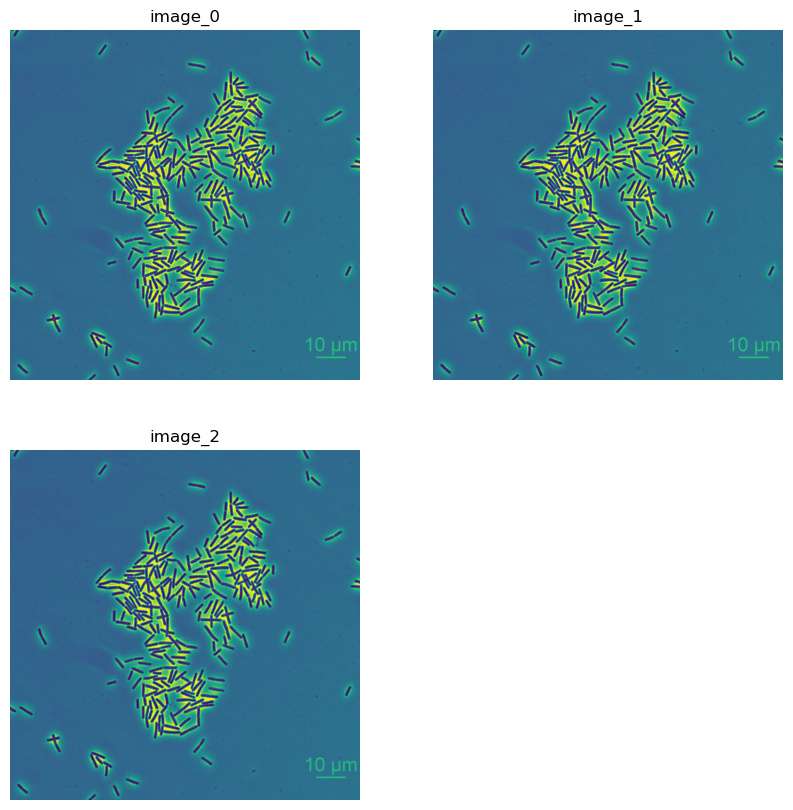

In [27]:
showImages([image_0, image_1, image_2])

In [3]:
img_path = "../images/20240917_delta6_6.tif"
image = io.imread(img_path, as_gray=True)

# normalize image to [0,255] and convert to uint8 for opencv compatability
image = (image*255).astype(np.uint8)




<tifffile.TiffFile '20240917_delta6_6.tif'> OME series cannot handle discontiguous storage ((1608, 1608, 3) != (3, 1608, 1608))


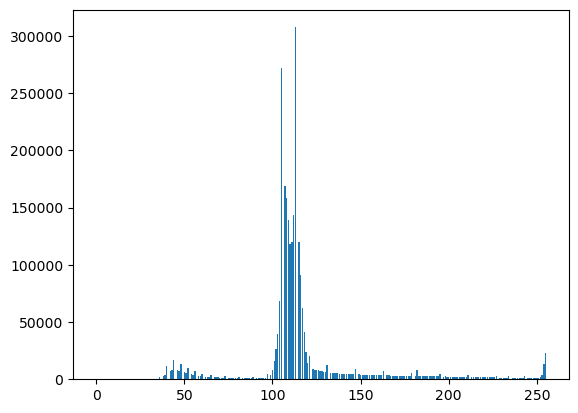

In [6]:
imageHistogram(image)

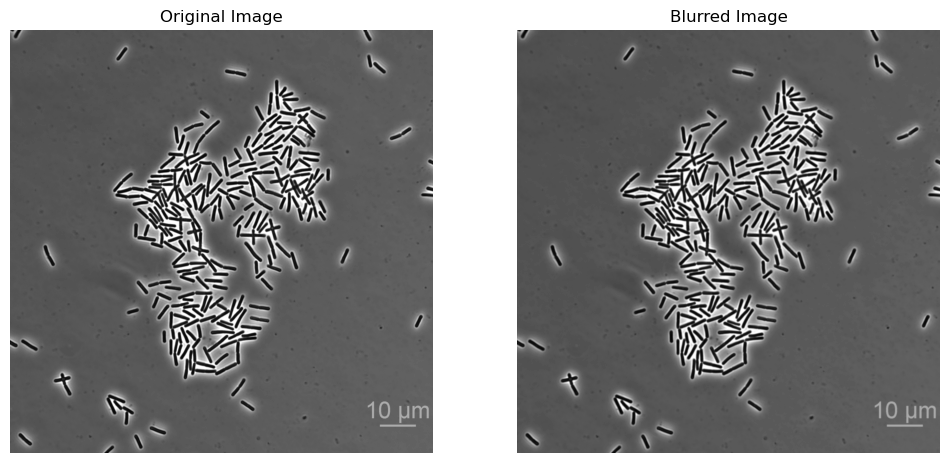

In [7]:
# gaussian blue to reduce noise before thresholding
blurred = cv.GaussianBlur(image, (5,5), 0)

# display image
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(blurred, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Blurred Image')
plt.show()





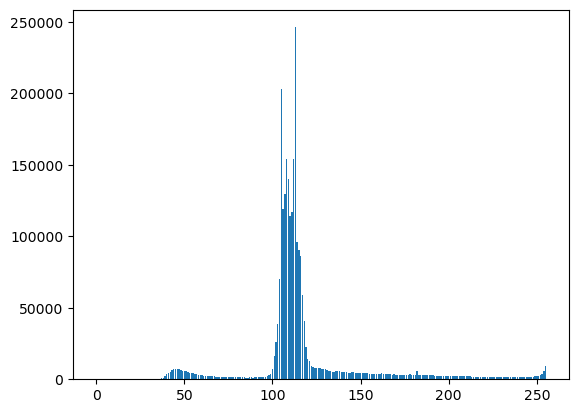

In [8]:
imageHistogram(blurred)

In [9]:
# apply otsu's thresholding
otsuthreshold, thres_otsu = cv.threshold(blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # when cv.THRESH_OTSU is used, the function ignores the thresh parameter
        # algorithm automatically determines the optimal threshold value using otsus method
        # then applies this threshold to create a binary image

print(otsuthreshold)
'''
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(blurred, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Blurred Image')
axes[1].imshow(thres_otsu, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Otsu Thresholded Image')
plt.tight_layout()
plt.show()'''







153.0


"\nfig, axes = plt.subplots(1, 2, figsize=(12, 6))\naxes[0].imshow(blurred, cmap='gray')\naxes[0].axis('off')\naxes[0].set_title('Blurred Image')\naxes[1].imshow(thres_otsu, cmap='gray')\naxes[1].axis('off')\naxes[1].set_title('Otsu Thresholded Image')\nplt.tight_layout()\nplt.show()"

(-0.5, 1607.5, 1607.5, -0.5)

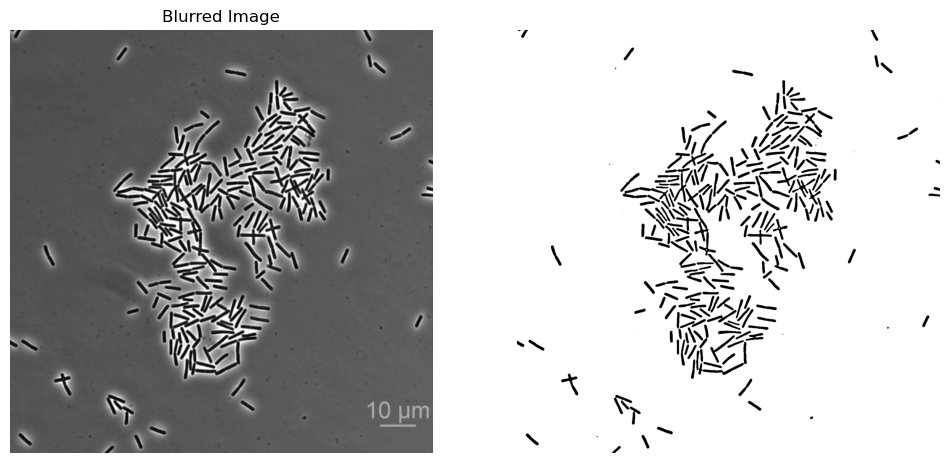

In [10]:
# manual thresholding
thres_value = 80
_, thres_manual = cv.threshold(blurred, thres_value, 255, cv.THRESH_BINARY)
    # blurred: input image
    # thres_value: threshold value
        # any pixel value greater than thres_value is set to 255, otherwise it is set to 0
    # 255: maximum pixel value. pixels that pass the threshold are set to 255
    # cv.THRESH_BINARY: specifies the type of thresholding to use.
        # in binary thresholding, pixels that pass the threshold are set to 255, otherwise they are set to 0
    # returns:
        # _: the threshold value used
        # thres_manual: the thresholded image

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(blurred, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Blurred Image')
axes[1].imshow(thres_manual, cmap='gray')
axes[1].axis('off')


In [31]:
def switch_background_foreground(image):
    # Assuming the image is binary, with 0 as background and 1 as foreground
    # We can switch the background and foreground by subtracting the image from 1
    return 255 - image



(-0.5, 1607.5, 1607.5, -0.5)

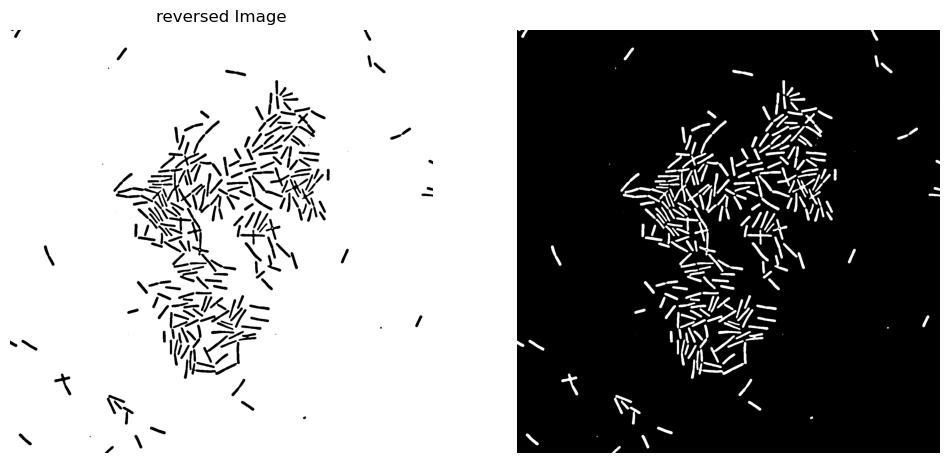

In [32]:
thres_manual2 = switch_background_foreground(thres_manual)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(thres_manual, cmap='gray')
axes[0].axis('off')
axes[0].set_title('reversed Image')
axes[1].imshow(thres_manual2, cmap='gray')
axes[1].axis('off')

### Watershed algorithm

1. preprocess (gaussian blur, thresholding) -> done
2. compute distance transform: highlights center of each object
3. identify sure foreground and background areas
4. apply watershed alforithm: use markers to segment and separate overlapping cells

In [33]:
# Step 1. apply distance transform to highlight cell centers
distance_transform = ndimage.distance_transform_edt(thres_manual2)
distance_transform1 = cv.distanceTransform(thres_manual2, cv.DIST_L2, 5) 
# calculates euclidean distance transform of a binary image
# for each non-zero pixel in teh binary image, it calculates the distance to the nearest zero pixel
    # thres_manual: binary image
    # cv.DIST_L2: type of distance metric to use (L2 represents euclidean distance)
    # 5: maximum distance value (sampling parameter)
# result is a new image (array) with each pixel representing the distance to the nearest zero (background)pixel


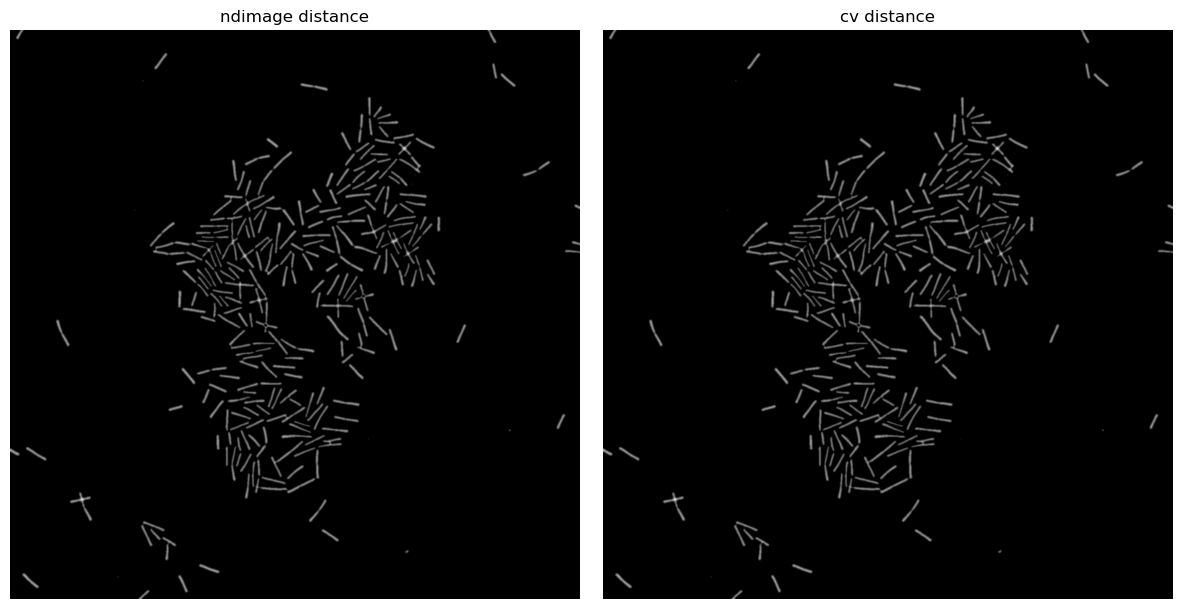

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(distance_transform, cmap='gray')
axes[0].axis('off')
axes[0].set_title('ndimage distance')
axes[1].imshow(distance_transform1, cmap='gray')
axes[1].axis('off')
axes[1].set_title('cv distance')
plt.tight_layout()
plt.show()

In [50]:
unique, counts = np.unique(distance_transform, return_counts=True)
for i in range(len(unique)):
    print(unique[i], counts[i])

0.0 2439179
1.0 32640
1.4142135623730951 12709
2.0 18719
2.23606797749979 11882
2.8284271247461903 12061
3.0 10130
3.1622776601683795 6839
3.605551275463989 10667
4.0 8886
4.123105625617661 5290
4.242640687119285 3202
4.47213595499958 4108
5.0 7025
5.0990195135927845 540
5.385164807134504 902
5.656854249492381 351
5.830951894845301 220
6.0 134
6.082762530298219 20
6.324555320336759 34
6.4031242374328485 36
6.708203932499369 15
7.0 31
7.0710678118654755 14
7.211102550927978 7
7.280109889280518 2
7.615773105863909 7
7.810249675906654 4
8.0 6
8.06225774829855 2
8.48528137423857 1
8.54400374531753 1


In [83]:
# Step 2. threshold the distance transform to get sure foreground
fg_threshold, sure_fg = cv.threshold(distance_transform, 0.2*distance_transform.max(), 255, cv.THRESH_BINARY)
    # 0.7*distance_transform.max(): threshold value
        # 70% of the maximum distance value in the distance transform image
        # pixels with value (distance) above this threshold will be considered as sure foreground
    # 255: maximum pixel value
    # 0: thresholding type (binary thresholding)
        # all pixels in the resulting image are either 0 or 255
print(fg_threshold)
sure_fg = np.uint8(sure_fg)
    # converts the sure foreground image to uint8 format
    # ensures compatibility with other functions that expect uint8 images


1.7088007490635062


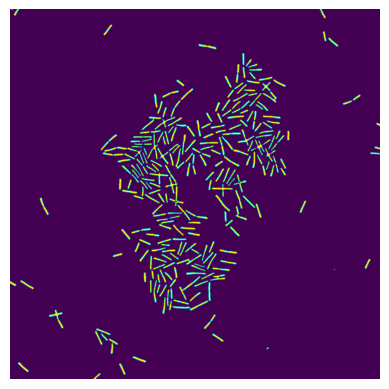

In [84]:
plt.imshow(sure_fg)
plt.axis('off')
plt.show()

In [132]:
# Step 3. Identify sure background using dilation
kernel = np.ones((7,7), np.uint8)
sure_bg = cv.dilate(sure_fg, kernel, iterations=1)
    # dilates the binary image using a 3x3 kernel
    # increases the size of the white region in the image

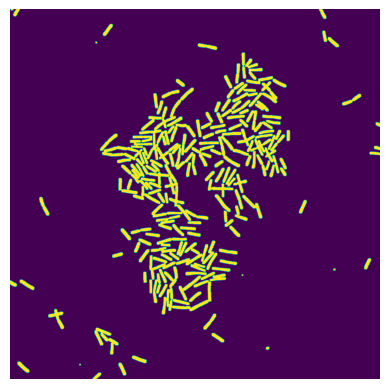

In [133]:
plt.imshow(sure_bg)
plt.axis('off')
plt.show()

In [134]:
# Step 4. subtract the sure foreground from the sure background to get unknown regions

unknown = cv.subtract(sure_bg, sure_fg)
    # subtracts the sure foreground from the sure background
    # result is an image with the unknown regions highlighted

# Step 5. label the sure foreground regions
_, markers = cv.connectedComponents(sure_fg)



    

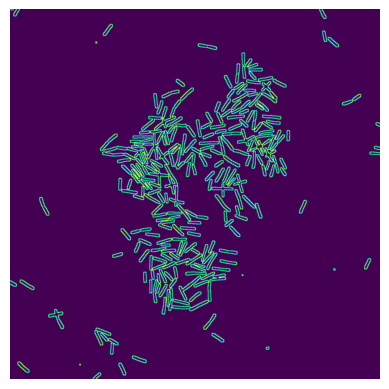

In [135]:
plt.imshow(unknown)
plt.axis('off')
plt.show()

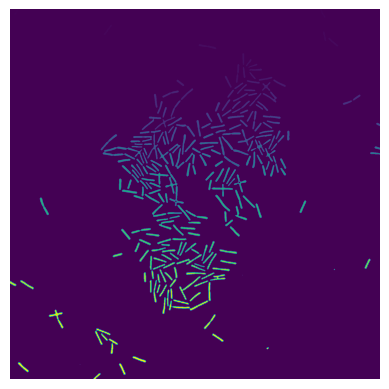

In [136]:
plt.imshow(markers)
plt.axis('off')
plt.show()

# Step 6. add 1 to all markers to ensure unknown regions are not 0
markers = markers + 1

# Step 7. mark the unknown regions with 0
markers[unknown==255] = 0

# Step 8. apply watershed algorithm
markers = cv.watershed(cv.cvtColor(blurred, cv.COLOR_GRAY2BGR), markers)
    # converts the grayscale image to a 3-channel BGR image
    # necessary for displaying the watershed lines in color



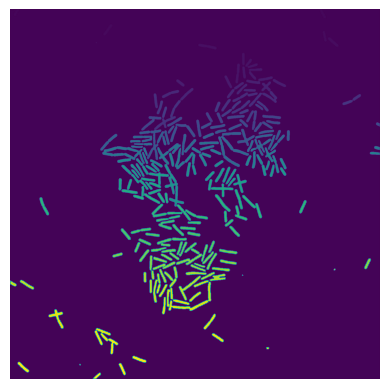

In [137]:
plt.imshow(markers)
plt.axis('off')
plt.show()

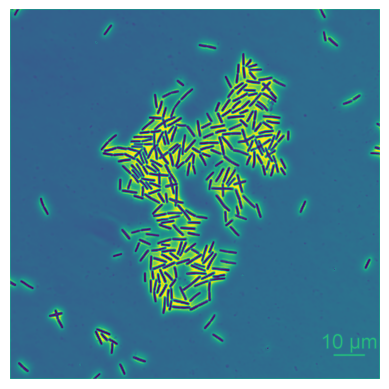

In [138]:
# mark the boundaries (-1) with a specific color for visualization
image_with_boundaries = blurred.copy()
image_with_boundaries[markers == -1] = [255]

# display image with boundaries
plt.imshow(image_with_boundaries)
plt.axis('off')
plt.show()


### count the number of cells

- find the number of connected components in the binary image
    - each connected component represents a cell


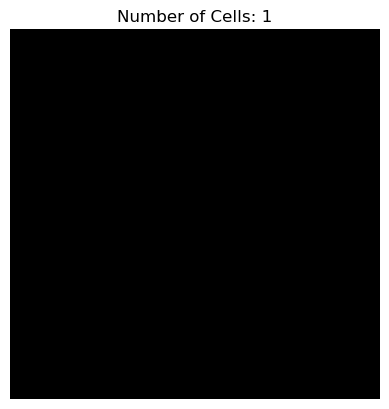

In [139]:
labeled_img, num_cells = ndimage.label(image_with_boundaries)
    # labeled_img: an array of the same size as the input image, where each connected component is assigned a unique integer label
    # num_cells: the number of connected components found in the image

plt.imshow(labeled_img, cmap='gray')
plt.title(f'Number of Cells: {num_cells}')
plt.axis('off')
plt.show()




